In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import time
from math import exp
from tqdm import tqdm

from rg.monotone import MLP1, MLP2
from rbm.rbm import RBM
from utils.losses import free_energy_contrast
from utils.newton import find_root
from utils.hmc import HMC
from utils.grad import batch_grad, grad
from utils.plots import plot1d, plot2d

In [2]:
lattice = 'lieb'
representation = 'a1e'

if lattice == 'lieb':
    from rbm.coupling_matrices import lieb as couplers
elif lattice == 'hex':
    from rbm.coupling_matrices import hex as couplers

if representation == 'a1': n_couplers = 1
elif representation == 'a1e': n_couplers = 2

fine_coupler = couplers[representation]['fine']
coarse_coupler = couplers[representation]['coarse']

In [3]:
device = torch.device('cuda')

# Models

In [4]:
flow = MLP2(
    dim=n_couplers, 
    h=64, 
    device=device
)
flow.eval();

In [5]:
fine = RBM(fine_coupler, device=device)
coarse = RBM(coarse_coupler, device=device)

In [6]:
sampler = HMC(device=device)

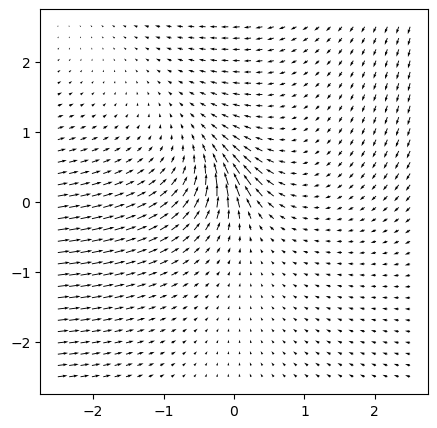

In [7]:
if n_couplers == 1:
    fig, ax = plot1d(flow, xlim=(-10, 10), device=device)
    ax.set_ylabel(r'$\nabla C$')
    ax.set_xlabel('J')
    ax.set_title('Untrained RG Flow (gradient of C-function)')
if n_couplers == 2:
    plot2d(flow, device=device);

# Training

In [8]:
epoch = 0
epochs = 2048
anneal_at = 512
n_models = 64
n_cd_samples = 1024
k_fine = 32
k_coarse = 1

beta = lambda epoch : 16/(1 + exp( -16 * (epoch - anneal_at) / epochs ))

In [9]:
optimizer = torch.optim.Adam(flow.parameters())

Js = []
losses = []
roots = []
J = torch.randn(n_models, n_couplers, device=device)

In [10]:
flow.train()
for epoch in tqdm(range(epoch, epoch + epochs)):
    optimizer.zero_grad()

    sampler.potential = lambda J : beta(epoch) * (flow(J) ** 2).sum(-1)

    # RG Flow
    J = sampler.step(J).detach()

    loss = 0

    fine.J = J
    coarse.J = J + flow(J)

    # Loss
    loss = free_energy_contrast(
        fine, coarse, 
        batch_size=n_cd_samples, 
        k_fine=k_fine, 
        k_coarse=k_coarse
    )
    loss.backward()
    optimizer.step()

    Js.append(J.clone().detach())
    losses.append(float(loss))
    #try:
    #    root = find_root(flow, torch.ones(n_couplers, device=device)).cpu().detach()
    #    roots.append(root if torch.all(torch.logical_and(root > -2, root < 2)) else torch.empty(2, 1))
    #except:
    #    roots.append(torch.tensor([float('nan')] * 2))

100%|███████████████████████████████████████| 2048/2048 [00:44<00:00, 45.89it/s]


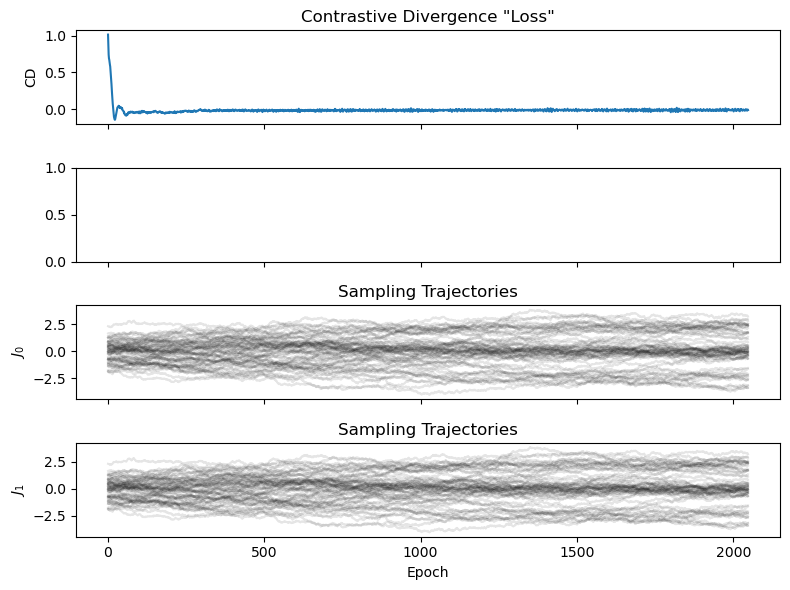

In [11]:
fig, axs = plt.subplots(n_couplers + 2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(losses)
axs[0].set_ylabel('CD')
axs[0].set_title('Contrastive Divergence "Loss"')

if len(roots) != 0:
    roots_tensor = torch.cat(roots, dim=1)
    axs[1].plot(roots_tensor[:, 0], roots_tensor[:, 1])
    axs[1].set_ylabel(r'$J_c$')
    axs[1].set_title('Critical Point')

for traj in torch.stack(Js, dim=2):
    for i in range(2, n_couplers+2):
        axs[i].plot(traj[0].cpu().detach(), alpha=0.1, c='black')

        axs[i].set_ylabel(rf'$J_{i-2}$')
        axs[i].set_title(r'Sampling Trajectories')

axs[-1].set_xlabel('Epoch')

plt.tight_layout()

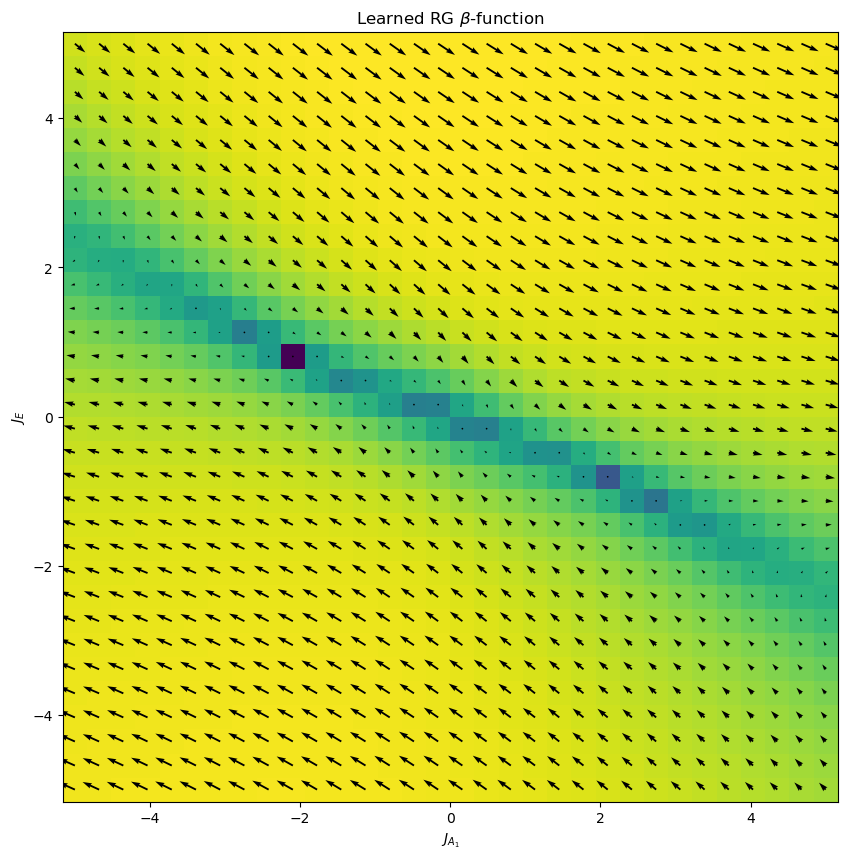

In [12]:
flow.eval()

if n_couplers == 1:
    fig, ax = plot1d(flow, xlim=(-2, 2), device=device)
    
    ax.set_ylabel(r'$\nabla C$')
    ax.set_title(r'Learned RG $\beta$-function')

    plt.tight_layout()

if n_couplers == 2:
    ax = plot2d(flow, sampler.potential, xlim=(-5, 5), ylim=(-5, 5), device=device)

    ax.set_xlabel(r'$J_{A_1}$')
    ax.set_ylabel(r'$J_{E}$')
    ax.set_title(r'Learned RG $\beta$-function')

#root = find_root(flow, torch.ones(n_couplers, device=device))
#print(root)